In [0]:
import pandas as pd
import numpy as np

import skimage
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

In [0]:
train = pd.read_csv('train_files.csv')

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
import zipfile

zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/Training.zip", 'r')
zip_ref.extractall("/content/tmp")
zip_ref.close()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
in_dir = "/content/tmp/Training"
data_paths = [os.path.join(pth, f) for pth, dirs, files in os.walk(in_dir) for f in files]

In [0]:
data_train_path = [os.path.join(in_dir, f) for f in train['file_name']]

In [0]:
from skimage.color import rgb2gray
train_img = []
for i in range(0, len(data_train_path)):
  img = skimage.img_as_float(skimage.io.imread(data_train_path[i])).astype(np.float32)
  # img_gray = rgb2gray(img)
  train_img.append(img)

In [0]:
train_img_resized = [skimage.transform.resize(train_img[i], (32, 32)) for i in range(0, len(train_img))]

In [0]:
train_x = np.array(train_img_resized)
# defining the target
train_y = train['annotation'].values
train_x.shape

(896, 32, 32, 3)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f683540d1d0>,
 <matplotlib.image.AxesImage at 0x7f6835370748>)

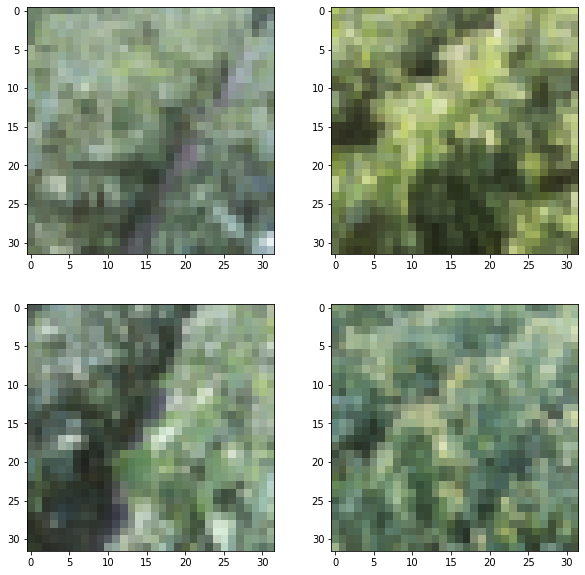

In [0]:
# visualizing images
i = 0
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(train_x[i])
plt.subplot(222), plt.imshow(train_x[i+25])
plt.subplot(223), plt.imshow(train_x[i+50])
plt.subplot(224), plt.imshow(train_x[i+75])

In [0]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((806, 32, 32, 3), (806,)), ((90, 32, 32, 3), (90,)))

In [0]:
# converting training images into torch format
train_x = train_x.reshape(806, 3, 32, 32)
train_x  = torch.from_numpy(train_x)

In [0]:
# converting the target into torch format
train_y = train_y.astype(int);
train_y = torch.from_numpy(train_y)

In [0]:
# shape of training data
train_x.shape, train_y.shape

(torch.Size([806, 3, 32, 32]), torch.Size([806]))

In [0]:
# converting validation images into torch format
val_x = val_x.reshape(90, 3, 32, 32)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([90, 3, 32, 32]), torch.Size([90]))

In [0]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(256, 5)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [0]:
# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.07)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=256, out_features=5, bias=True)
  )
)


In [0]:
model = model.double()
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()

    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_val)
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    if epoch%2 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)

In [0]:
# defining the number of epochs
n_epochs = 25
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(1.8515, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  3 	 loss : tensor(4.0390, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  5 	 loss : tensor(1.8453, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  7 	 loss : tensor(1.1993, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  9 	 loss : tensor(1.2419, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  11 	 loss : tensor(1.3444, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  13 	 loss : tensor(1.3443, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  15 	 loss : tensor(1.2938, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  17 	 loss : tensor(1.2024, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackward>)
Epoch :  19 	 loss : tensor(1.1167, device='cuda:0', dtype=torch.float64, grad_fn=<NllLossBackwa

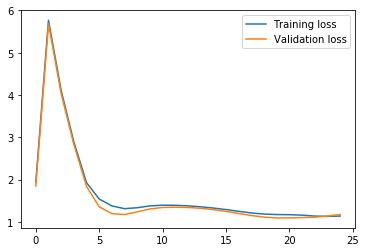

In [0]:
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [0]:
# prediction for training set
with torch.no_grad():
    output = model(train_x.cuda())
    
softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on training set
accuracy_score(train_y, predictions)

0.5099255583126551

In [0]:
# prediction for validation set
with torch.no_grad():
    output = model(val_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

# accuracy on validation set
accuracy_score(val_y, predictions)

0.5111111111111111

In [0]:
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/Project_C2_Testing-20191129T063942Z-001.zip", 'r')
zip_ref.extractall("/content/test")
zip_ref.close()

In [0]:
import os
in_test_dir = "/content/test/Project_C2_Testing"
data_test_paths = [os.path.join(pth, f) for pth, dirs, files in os.walk(in_test_dir) for f in files]

In [0]:
from skimage.color import rgb2gray
test_img = []
for i in range(0, len(data_test_paths)):
  timg = skimage.img_as_float(skimage.io.imread(data_test_paths[i])).astype(np.float32)
  timg_gray = rgb2gray(timg)
  test_img.append(timg_gray)

In [0]:
test_img_resized = [skimage.transform.resize(test_img[i], (32, 32)) for i in range(0, len(test_img))]

In [0]:
test_x = np.array(test_img_resized)
test_x.shape

(129, 32, 32)

In [0]:
test_x = test_x.reshape(129, 1, 32, 32)
test_x  = torch.from_numpy(test_x)
test_x.shape

torch.Size([129, 1, 32, 32])

In [0]:
with torch.no_grad():
    output = model(test_x.cuda())

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

In [0]:
predictions[:]

array([4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0,
       0, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4, 4, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 4, 0, 0, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 2, 0, 4, 4, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0])